Імпорт бібліотек

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt

Підготовка даних

In [19]:
df = pd.read_csv("/content/forecast_of_market_dataset.csv")

df['month'] = pd.to_datetime(df['month'], errors='coerce')

eval_period = (df['month'] >= '2024-01-01') & (df['month'] <= '2024-12-31')
test_df = df[eval_period].copy()

train_df = df[df['month'] < '2024-01-01'].copy()

forecast_dates = pd.date_range('2024-01-01', '2024-12-01', freq='MS')


Запуск моделі

In [20]:
product_groups = train_df['product_group_id'].unique()
results = []

for group_id in tqdm(product_groups, desc="Forecasting per product group"):
    group_train = train_df[train_df['product_group_id'] == group_id]

    # Loop over both targets
    for target_col in ['market_revenue', 'revenue_amazon']:
        series = group_train[['month', target_col]].dropna()
        series = series.rename(columns={'month': 'ds', target_col: 'y'})

        if len(series) < 12 or series['y'].nunique() <= 1:
            continue  # Skip sparse or flat series

        model = Prophet()
        try:
            model.fit(series)
            future = pd.DataFrame({'ds': forecast_dates})
            forecast = model.predict(future)[['ds', 'yhat']]

            # Add metadata
            forecast['product_group_id'] = group_id
            forecast['target'] = target_col
            results.append(forecast)
        except Exception as e:
            print(f"⚠️ Skipped {target_col} for group {group_id}: {e}")
            continue

Forecasting per product group:   0%|          | 0/29 [00:00<?, ?it/s]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpinz_3uw1/eenap5lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpinz_3uw1/paimu7kb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9895', 'data', 'file=/tmp/tmpinz_3uw1/eenap5lq.json', 'init=/tmp/tmpinz_3uw1/paimu7kb.json', 'output', 'file=/tmp/tmpinz_3uw1/prophet_model9pi8lbsn/prophet_model-20250526102547.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstan

Об'єднання результатів прогнозу з фактом

In [21]:
forecast_df = pd.concat(results, ignore_index=True)
actual_df = test_df.melt(
    id_vars=['month', 'product_group_id'],
    value_vars=['market_revenue', 'revenue_amazon'],
    var_name='target',
    value_name='actual'
).rename(columns={'month': 'ds'})

results_merged = pd.merge(forecast_df, actual_df, on=['product_group_id', 'ds', 'target'], how='inner')


Розрахунок метрик

In [22]:
results_merged['abs_error'] = (results_merged['actual'] - results_merged['yhat']).abs()
results_merged['pct_error'] = results_merged['abs_error'] / results_merged['actual'].replace(0, np.nan)
results_merged['weighted_error'] = results_merged['abs_error'] * results_merged['actual']

results_clean = results_merged.dropna(subset=['actual', 'yhat'])


Відображення результатів

In [23]:

metrics = results_clean.groupby('target').agg(
    MAE=('abs_error', 'mean'),
    MAPE=('pct_error', lambda x: np.mean(x.dropna()) * 100)
).reset_index()

wmape_df = results_clean.groupby('target').apply(
    lambda g: (g['weighted_error'].sum() / g['actual'].sum()) * 100
).reset_index().rename(columns={0: 'WMAPE'})

metrics = pd.merge(metrics, wmape_df, on='target')


print(metrics)

           target           MAE       MAPE         WMAPE
0  market_revenue  8.736675e+08  20.923066  2.798600e+11
1  revenue_amazon  9.531870e+07  20.689679  2.488396e+10


<ipython-input-23-3b7155a6ad9c>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wmape_df = results_clean.groupby('target').apply(


<ipython-input-24-d4b254833148>:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


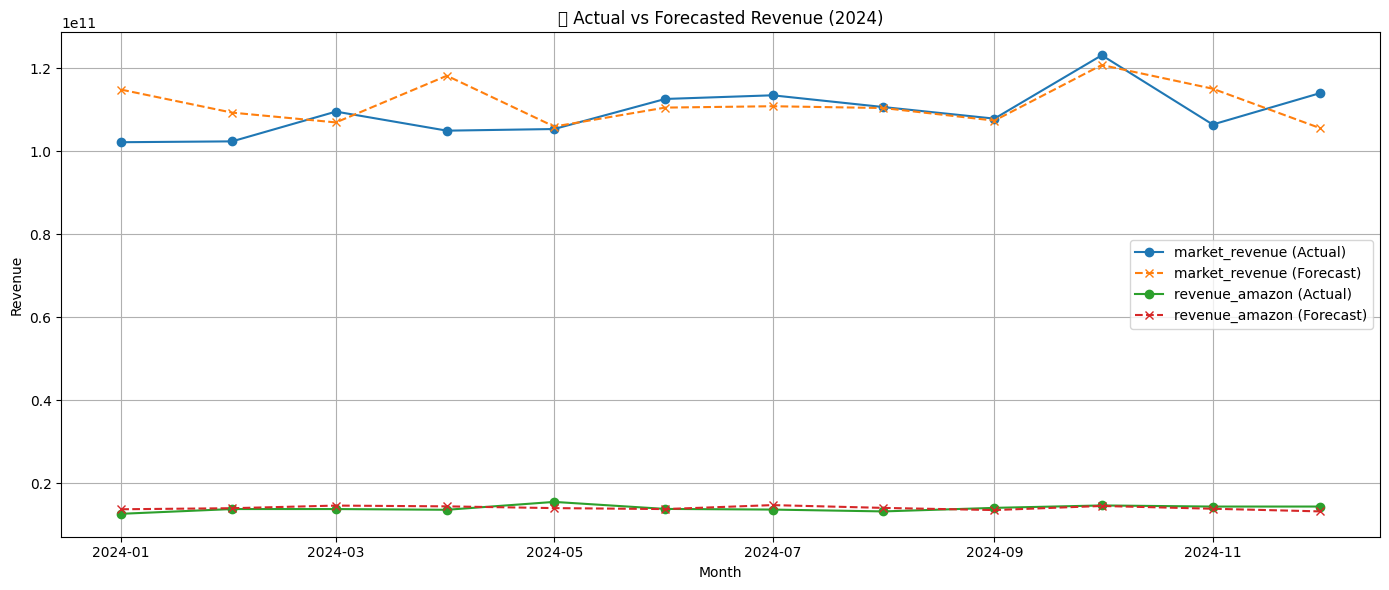

In [24]:

plot_df = results_clean.groupby(['ds', 'target']).agg({
    'actual': 'sum',
    'yhat': 'sum'
}).reset_index()

plt.figure(figsize=(14, 6))
for target in plot_df['target'].unique():
    subset = plot_df[plot_df['target'] == target]
    plt.plot(subset['ds'], subset['actual'], marker='o', label=f"{target} (Actual)")
    plt.plot(subset['ds'], subset['yhat'], marker='x', linestyle='--', label=f"{target} (Forecast)")

plt.title("📉 Actual vs Forecasted Revenue (2024)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
!pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpinz_3uw1/vukr3r08.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpinz_3uw1/qshfk3gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23372', 'data', 'file=/tmp/tmpinz_3uw1/vukr3r08.json', 'init=/tmp/tmpinz_3uw1/qshfk3gq.json', 'output', 'file=/tmp/tmpinz_3uw1/prophet_model8oqij6mu/prophet_model-20250526102823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:28:23 - cmdstanpy - INFO - Chai

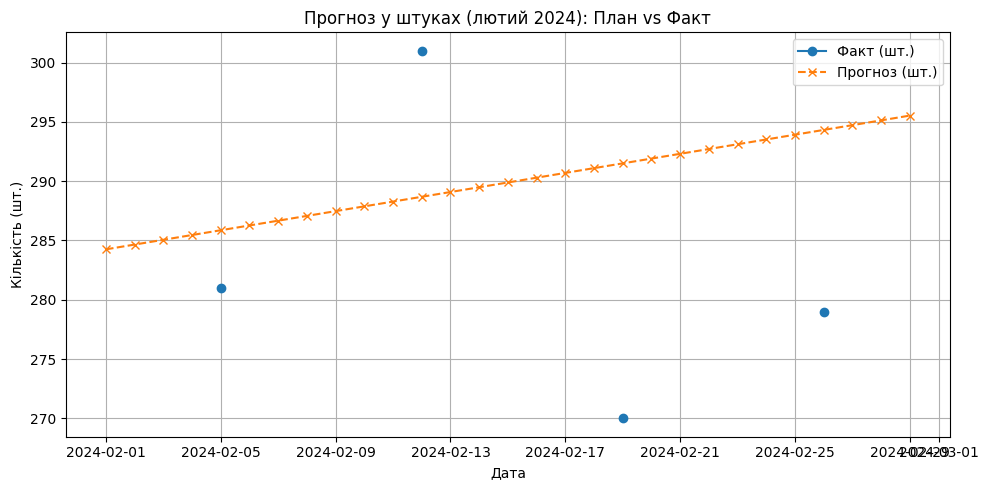

MAPE для штукової моделі за лютий 2024: 4.82%


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Завантаження датасету зі штуками
df_pcs = pd.read_csv("/content/dataset_pcs.csv")
df_pcs["period"] = pd.to_datetime(df_pcs["period"], errors="coerce")

# Агрегація по днях
df_grouped = df_pcs.groupby("period")["orders_qty"].sum().reset_index()
df_grouped.columns = ["ds", "y"]

# Тренувальні дані до лютого
train_df = df_grouped[df_grouped["ds"] < "2024-02-01"]

# Створення і навчання моделі
model = Prophet()
model.fit(train_df)

# Прогноз на лютий 2024
future = pd.date_range(start="2024-02-01", end="2024-02-29", freq="D")
future_df = pd.DataFrame({"ds": future})
forecast = model.predict(future_df)

# З'єднання з фактичними даними
actual_feb = df_grouped[(df_grouped["ds"] >= "2024-02-01") & (df_grouped["ds"] <= "2024-02-29")]
forecast_feb = forecast[["ds", "yhat"]]
merged_feb = pd.merge(forecast_feb, actual_feb, on="ds", how="left")

# Обчислення MAPE
merged_feb["mape"] = np.abs(merged_feb["y"] - merged_feb["yhat"]) / merged_feb["y"].replace(0, np.nan)
mape_value = merged_feb["mape"].mean() * 100

# Побудова графіку
plt.figure(figsize=(10, 5))
plt.plot(merged_feb["ds"], merged_feb["y"], label="Факт (шт.)", marker="o")
plt.plot(merged_feb["ds"], merged_feb["yhat"], label="Прогноз (шт.)", linestyle="--", marker="x")
plt.title("Прогноз у штуках (лютий 2024): План vs Факт")
plt.xlabel("Дата")
plt.ylabel("Кількість (шт.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"MAPE для штукової моделі за лютий 2024: {mape_value:.2f}%")
